# MIE1624 Introducation to Data Science Course Project - Group 13

### The goal of the project is to identify skill set that are required to be a successful data scientist, prepare an introductory course and maters degree curriculum catering to these skill sets for different student groups. To do this analysis, we primarily used the Kaggle ML and Data Science 2017 Survey data set which the response is given by data scientist and machine learning practitioners to comprehensive questions related to data science.  Further to identify the required skill in demand in the job market we collected data from indeed. 

## 1. Importing all Necessary Libraries and writing Functions

In [1]:
#importing and installing all necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
%matplotlib inline
import urllib
import requests
!pip install bs4
import bs4
from bs4 import BeautifulSoup
import re

/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


  Running setup.py bdist_wheel for bs4 ... - done
  Stored in directory: /home/notebook/.cache/pip/wheels/84/67/d4/9e09d9d5adede2ee1c7b7e8775ba3fbb04d07c4f946f0e4f11
Successfully built bs4
You are using pip version 9.0.1, however version 9.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
#to have great graph
sns.set()
sns.set_palette(sns.cubehelix_palette(10, start=1.7, reverse=True))

In [11]:
# we create functions for various tasks and recall them to do the required analysis
#Takes a dataframe and multiple answer question stem, returns barplot of counts in descending order
def select_all_that_apply_plot(df, question, figsize=(12,36)):
     
    """
    :param df: a DataFrame containing survey results
    :param question_stem: a string containing the question name
    :param figsize: a tuple containing desired figure dimenstions, default = (12,36)
    """
    filtered = pd.DataFrame(df.loc[:,df.columns.str.startswith(question)])
    split = filtered[question].dropna().str.split(',').tolist()
    

    flattened = []
    for i in split:
        for j in i:
            flattened.append(j)
            
    flattened_DF = pd.DataFrame(flattened, columns=[question])
    plt.figure(figsize=(12,6))

    ax = sns.countplot(y=question, data=flattened_DF, order=flattened_DF[question].value_counts().index);
    plt.setp(ax.get_yticklabels(), fontsize=10)
    plt.ylabel('');
    plt.title(question + ', N = ' + str(len(filtered)))
    plt.show()
    
    return



In [4]:
def multi_plot_hist(df, question_stem, figsize=(24,18)):
    
    #Takes a dataframe and a question stem to a multiple-part question, returns histogram of counts. Useful for
    #percentage responses.
   
    #create a new DataFrame made of only the columns we care about
    filtered = pd.DataFrame(df.loc[:,df.columns.str.startswith(question_stem)]).dropna()
    
    num_columns = len(filtered.columns)
    plt.figure(figsize=figsize)
    
    #Create subplots for each question
    for i in range(num_columns):
        plt.subplot(math.ceil(num_columns/3),3,i+1)
        plt.title(filtered.columns[i][len(question_stem):])
        plt.xlabel('Percentage')
        plt.hist(filtered[filtered.columns[i]], rwidth=0.8)

    plt.show()
    return filtered

In [5]:

def replace_usefulness(df, question_stem):
    #Takes a DataFrame and a question stem. Replaces 'Very Useful' with 1, 'Somewhat Useful with 0.5. and 'Not Useful' with 0
    
    #Create a new DataFrame from only the questions we care about
    filtered = pd.DataFrame(df.loc[:,df.columns.str.startswith(question_stem)])
    
    #Replace words with useful numbers
    filtered.replace({
        'Very useful' : 1,
        'Somewhat useful' : 0.5,
        'Not Useful' : 0,
        np.nan : 0
    }, inplace=True)
    
    return filtered

In [6]:


def plot_usefulness_questions(df, question_stem, figsize=(12,36), drop_last=None):
    
    #Plots a scaled frequency chart for multiple, related questions about usefuless.
    
    #Use our replace_usefuless function
    replaced = replace_usefulness(df, question_stem)
    
    #Add up all the values, sort them
    normed = replaced.sum().sort_values(ascending=False)
   
    #Remove the question stem from each row index, leaving only the unique sub-question text
    normed.index=[s[len(question_stem):] for s in normed.index]
    
    #Drop some of the last ones if needed
    if drop_last != None: 
        normed.drop(normed.index[-1*drop_last:], inplace=True)
    
    plt.figure(figsize=figsize)
    ax = sns.barplot(y = normed.index, x = normed)
    plt.setp(ax.get_yticklabels(), fontsize=15)
    plt.title(question_stem + ', N = ' + str(len(replaced)))
    plt.xlabel('Usefulness')
    plt.show()
    
    return normed

In [7]:

#Next two function repeat previous two but for frequency instead of usefulness. 
def replace_frequency(df, question_stem):
    
    #Takes a DataFrame and a question stem, plots a scaled graph about usefulness.
    
    filtered = pd.DataFrame(df.loc[:,df.columns.str.startswith(question_stem)])
    filtered.replace({
        'Most of the time' : 1,
        'Often' : 0.6,
        'Sometimes' : 0.25,
        'Rarely' : 0.1,
        #np.nan : 0
    }, inplace=True)
    
    return filtered

In [8]:

def plot_frequency_questions(df, question_stem, figsize=(12,36), drop_last=None):
    
    #Plots a scaled frequency chart for multiple, related questions about frequency of use.
    
    replaced = replace_frequency(df, question_stem)
    normed = replaced.sum().sort_values(ascending=False)
    
    normed.index=[s[len(question_stem):] for s in normed.index]
    if drop_last != None: 
        normed.drop(normed.index[-1*drop_last:], inplace=True)
    
    plt.figure(figsize=figsize)
    ax = sns.barplot(y = normed.index, x = normed)
    plt.setp(ax.get_yticklabels(), fontsize=15)
    plt.title(question_stem + ', N = ' + str(len(replaced)))
    plt.xlabel('Raw Score')
    plt.show()
    
    return normed

In [9]:

#Repeat previous function but for importance.
def replace_importance(df, question_stem):
    
    #Takes a DataFrame and a question stem. Plots a scaled graph about importance.
   
    filtered = pd.DataFrame(df.loc[:,df.columns.str.startswith(question_stem)])
    
    if 'Necessary' in filtered.values:
        replacements = {
            'Necessary' : 1,
            'Nice to have': 0.5,
            'Unnecessary' : 0,
            np.nan : 0
        }
    else:
        replacements = {
            'Very Important' : 1,
            'Somewhat important' : 0.5,
            'Not important' : 0,
            np.nan : 0
        }
    
    filtered.replace(replacements, inplace=True)
    
    return filtered

In [10]:

def plot_importance_questions(df, question_stem, figsize=(12,36), drop_last=None):
    
    #Plots a scaled frequency chart for multiple, related questions about frequency of use.
   
    replaced = replace_importance(df, question_stem)
    normed = replaced.sum().sort_values(ascending=False)
                            
    normed.index=[s[len(question_stem):] for s in normed.index]
    if drop_last != None: 
        normed.drop(normed.index[-1*drop_last:], inplace=True)
    
    plt.figure(figsize=figsize)
    ax = sns.barplot(y = normed.index, x = normed)
    plt.setp(ax.get_yticklabels(), fontsize=15)
    plt.title(question_stem + ', N = ' + str(len(replaced)))
    plt.xlabel('Importance')
    plt.show()
    
    return normed

In [12]:


#Importing the multiple choice responses
MC = pd.read_csv('multipleChoiceResponses.csv', encoding='latin-1', low_memory=False)



## 2. Visualizing the data and assay opinions of data scientists 

/usr/local/lib/python3.5/dist-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


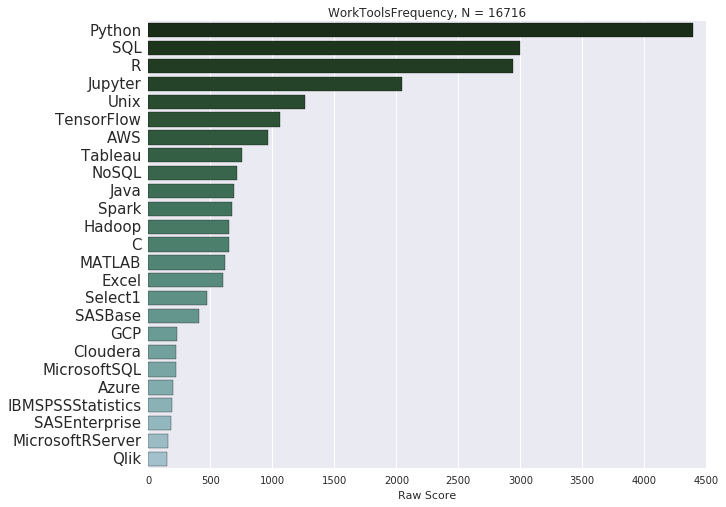

In [13]:
# Plotting the Tools that are used in the industry
sns.set_palette(sns.cubehelix_palette(30, start=1.7, reverse=True))
plot_frequency_questions(MC, 'WorkToolsFrequency', figsize=(10,8), drop_last=25);

#### 2.1 Based in this plot it is inferred that python has been most commonly used tools by data science practitioner followed by SQL and R, almost 25 % of the practitioner use python as the primary tool for analysis, Based on this fact we decided to adopt python for all our courses.

/usr/local/lib/python3.5/dist-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


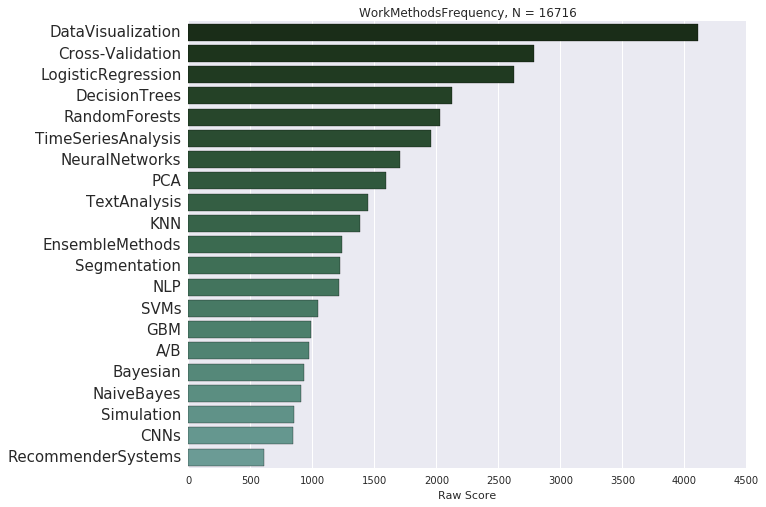

In [78]:
# Plotting the Most used ML methods in Industry
sns.set_palette(sns.cubehelix_palette(35, start=1.7, reverse=True))
plot_frequency_questions(MC, 'WorkMethodsFrequency', figsize=(10,8), drop_last = 12);

#### 2.2 We visualized the work method frequency, which tell us how frequently these tools were used. As expected data visualization was on top which signifies the important of doing an exploratory analysis. We there for incorporated a separate lecture on data visualization. Further it is observed that Time series analysis is used significantly however this topic is not included in the present data curriculum so decided to add this to the curriculum(for MIE 1624).

/usr/local/lib/python3.5/dist-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


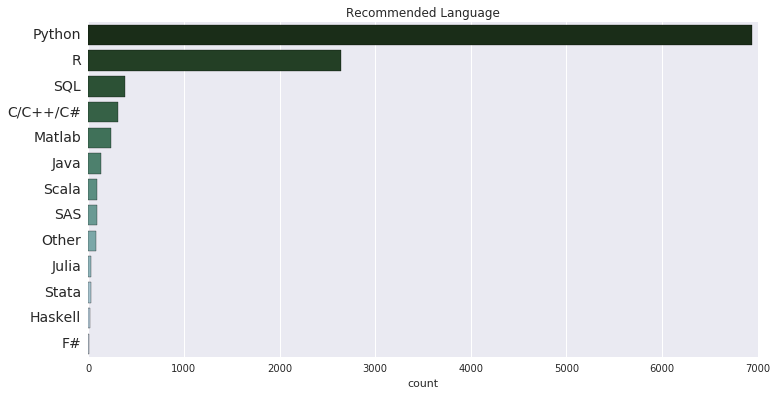

In [15]:
# Plotting the most recommended language to learn by Data Scientists
plt.figure(figsize=(12,6))
plt.title('Recommended Language')
sns.set_palette(sns.cubehelix_palette(13, start=1.7, reverse=True))
#A countplot is like a histogram for a discrete range. It just goes through a column, keeping a running tab of the values it finds.
ax = sns.countplot(data=MC, y='LanguageRecommendationSelect', order=MC['LanguageRecommendationSelect'].value_counts().index);
plt.ylabel('')
plt.setp(ax.get_yticklabels(), fontsize=14);

#### 2.3 Referring to section 2.2, Not only most practitioners use python they also recommend studying or starting with python data analytics. which further substantiate our decision  for using python as the  tool for data analysis

/usr/local/lib/python3.5/dist-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


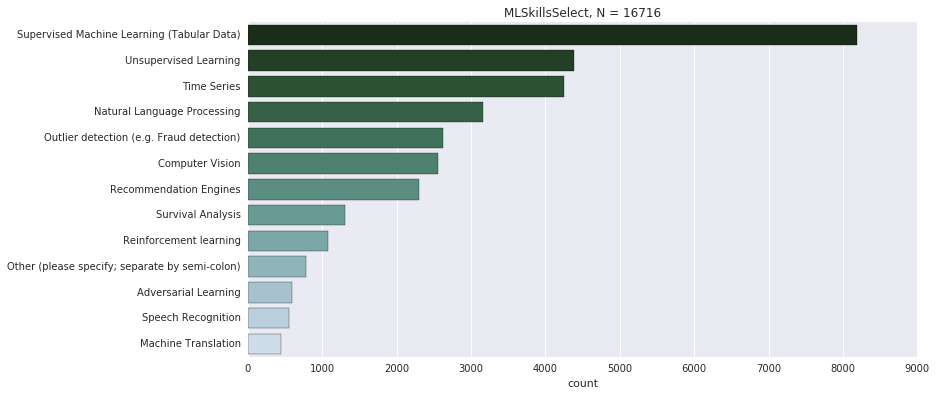

In [16]:
# Plotting the Most used Machine Learning skills
sns.set_palette(sns.cubehelix_palette(13, start=1.7, reverse=True))
select_all_that_apply_plot(MC, 'MLSkillsSelect', figsize=(10,8))

#### 2.4 This visualization shows the most used machine learning topics, Further 2.5, also outlays the most commonly used ML concepts. Based on these two section we crafted our lectures and courses on machine learning

/usr/local/lib/python3.5/dist-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


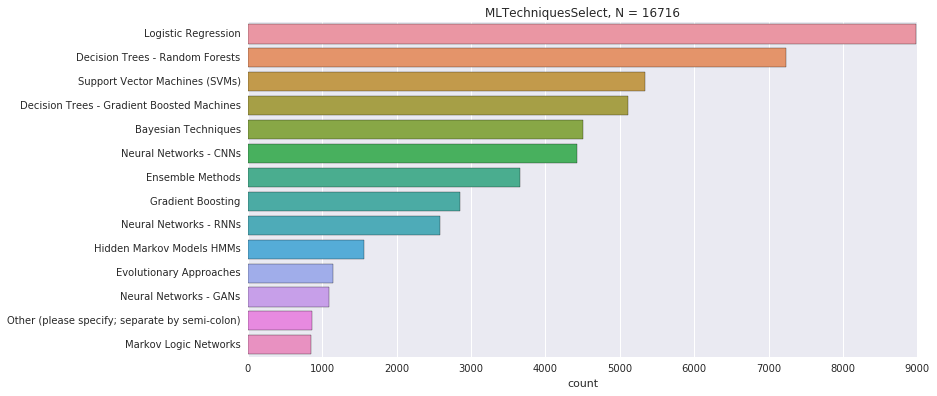

In [17]:
# Plotting the most used Machine Learning Techniques
sns.set_palette(sns.cubehelix_palette(13, start=1.7, reverse=True))
select_all_that_apply_plot(MC, 'MLTechniquesSelect', figsize=(10,8))

#### 2.5) Refer 2.4

/usr/local/lib/python3.5/dist-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


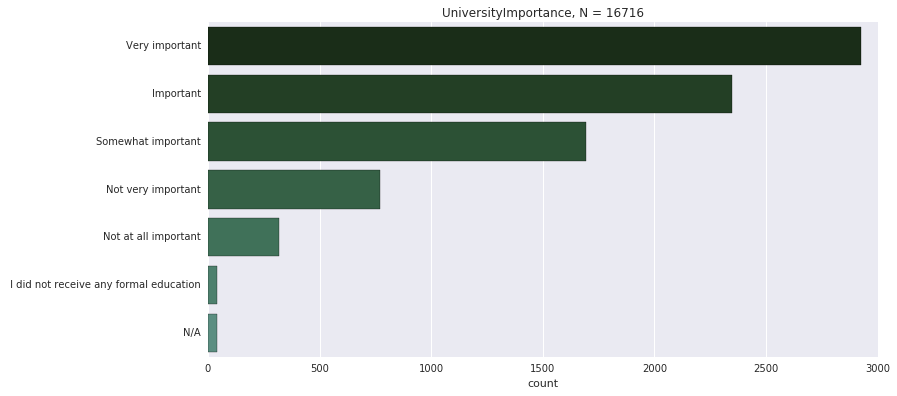

In [18]:
#Finding How much impact University has on Data Science field
sns.set_palette(sns.cubehelix_palette(13, start=1.7, reverse=True))
select_all_that_apply_plot(MC, 'UniversityImportance', figsize=(10,8))

####    2.6 It is interesting note that majority of data scientist practitioners find that have an university degree had a great significance in serving as data analyst. This outlays the importance of having a well laid curriculum for a Master program for data science  

/usr/local/lib/python3.5/dist-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


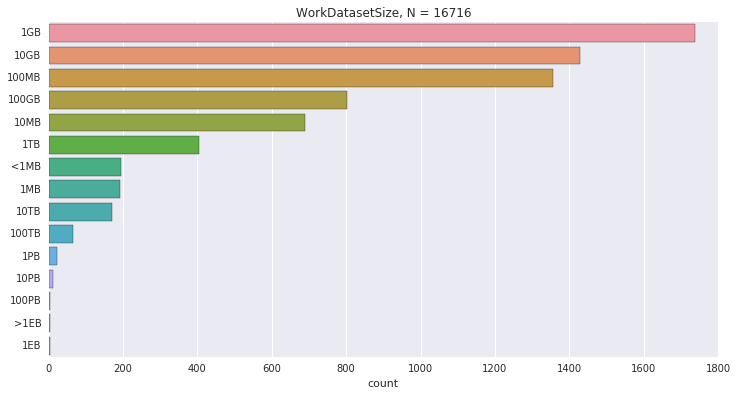

In [19]:
# Plotting Real Time Data set size in the industry 
sns.set_palette(sns.cubehelix_palette(13, start=1.7, reverse=True))
select_all_that_apply_plot(MC, 'WorkDatasetSize', figsize=(10,8))

#### 2.7 It can be observed from the above result that data scientist usually handle huge data sets, hence it is important for them to manage such huge data sets, therefore we introduced course/lecture in data base management system

/usr/local/lib/python3.5/dist-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


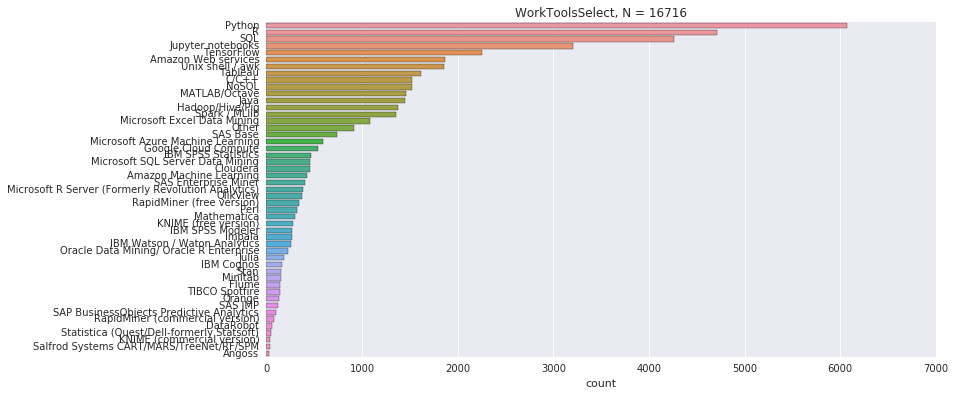

In [20]:
# Tools that are used by Data Scientists
sns.set_palette(sns.cubehelix_palette(13, start=1.7, reverse=True))
select_all_that_apply_plot(MC, 'WorkToolsSelect', figsize=(10,8))

/usr/local/lib/python3.5/dist-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


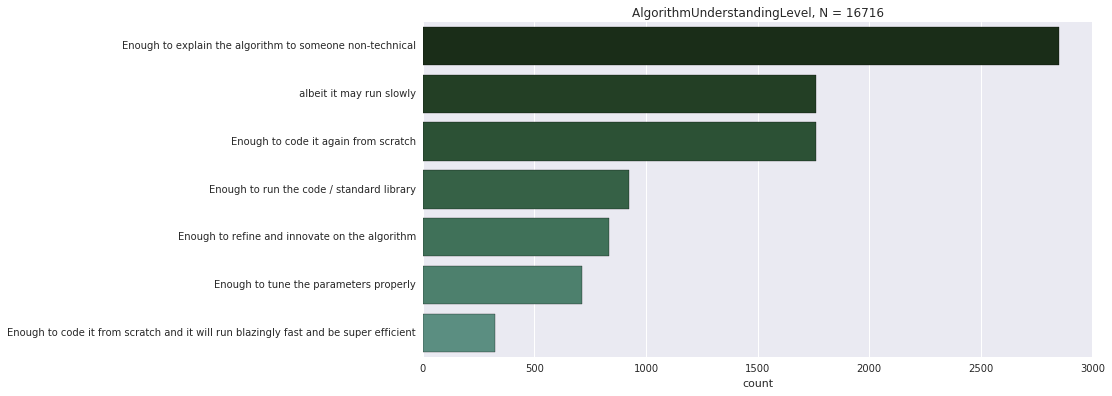

In [21]:
# Understanding Algorithm
sns.set_palette(sns.cubehelix_palette(13, start=1.7, reverse=True))
select_all_that_apply_plot(MC, 'AlgorithmUnderstandingLevel', figsize=(10,8))

/usr/local/lib/python3.5/dist-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


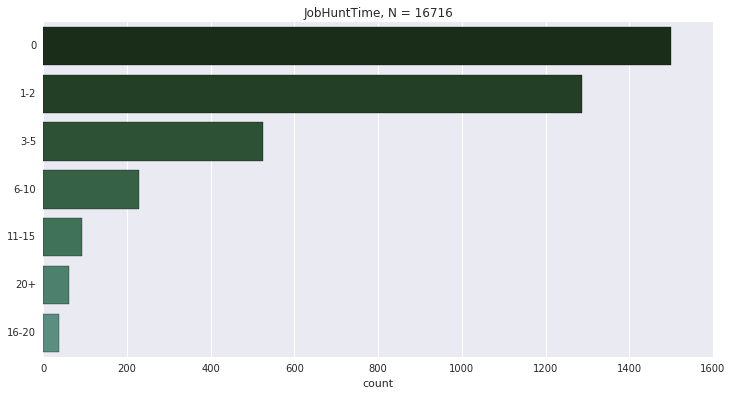

In [22]:
# Plotting the Job Hunt time in Years
sns.set_palette(sns.cubehelix_palette(13, start=1.7, reverse=True))
select_all_that_apply_plot(MC, 'JobHuntTime', figsize=(10,8))


/usr/local/lib/python3.5/dist-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


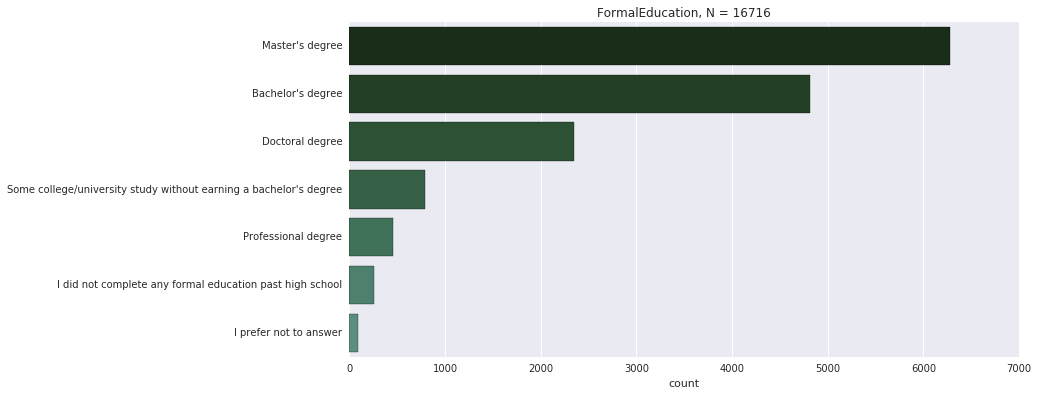

In [23]:
# Plotting the Educational Level of the Data Scientists
sns.set_palette(sns.cubehelix_palette(13, start=1.7, reverse=True))
select_all_that_apply_plot(MC, 'FormalEducation', figsize=(10,8))

Just over half of the respondents have more than a Bachelor's degree.

/usr/local/lib/python3.5/dist-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


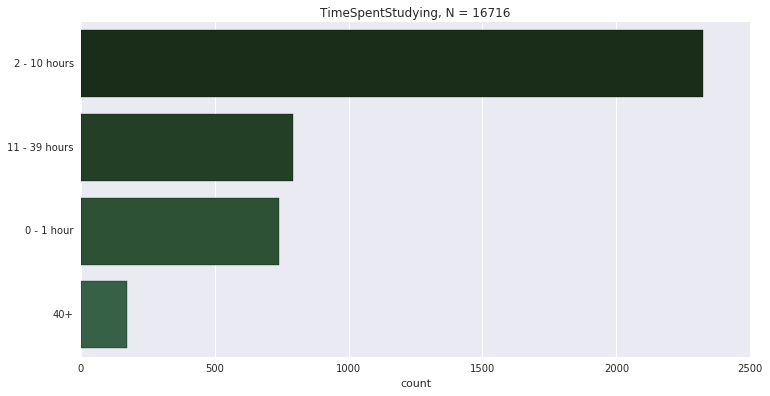

In [24]:
# Time spent on Studying for Weekly basis
sns.set_palette(sns.cubehelix_palette(13, start=1.7, reverse=True))
select_all_that_apply_plot(MC, 'TimeSpentStudying', figsize=(10,8))

/usr/local/lib/python3.5/dist-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


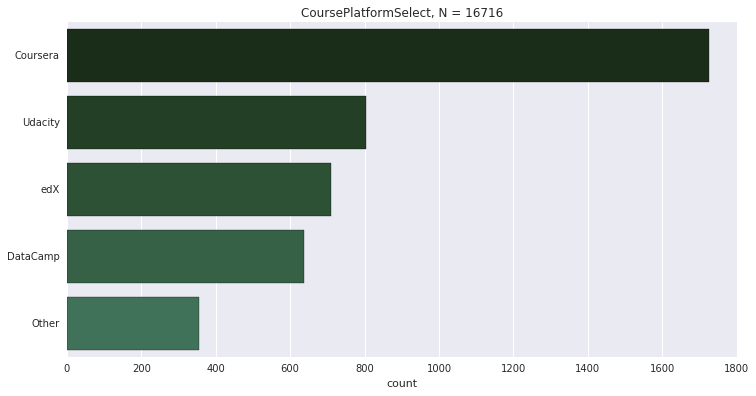

In [25]:
# Course Platform used for Learning Data Science
sns.set_palette(sns.cubehelix_palette(13, start=1.7, reverse=True))
select_all_that_apply_plot(MC, 'CoursePlatformSelect', figsize=(10,8))

/usr/local/lib/python3.5/dist-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


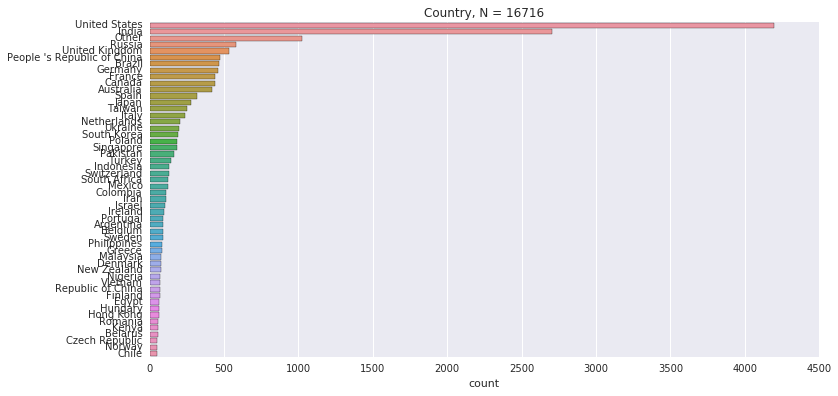

In [26]:
#Countries where most of the Data Scientist live
sns.set_palette(sns.cubehelix_palette(13, start=1.7, reverse=True))
select_all_that_apply_plot(MC, 'Country', figsize=(10,8))


/usr/local/lib/python3.5/dist-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


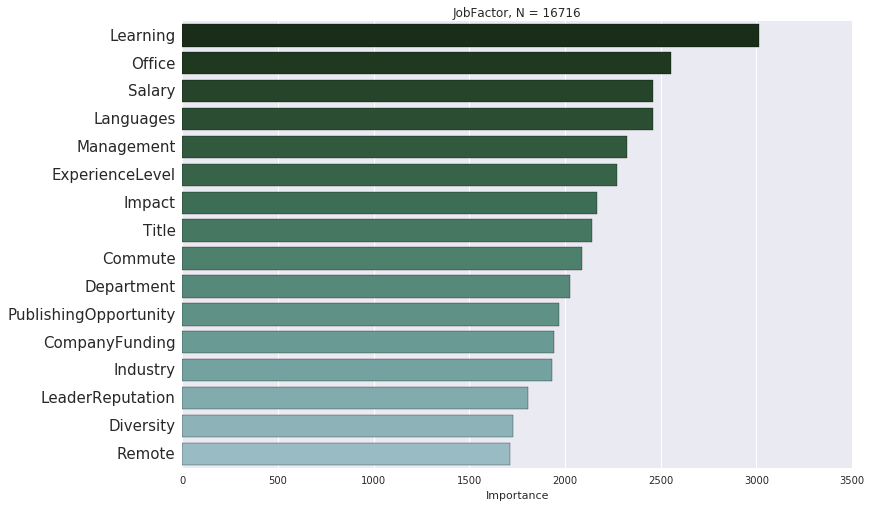

In [27]:
#Job Factor Data
sns.set_palette(sns.cubehelix_palette(20, start=1.7, reverse=True))
plot_importance_questions(MC, 'JobFactor', figsize=(12,8));

/usr/local/lib/python3.5/dist-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


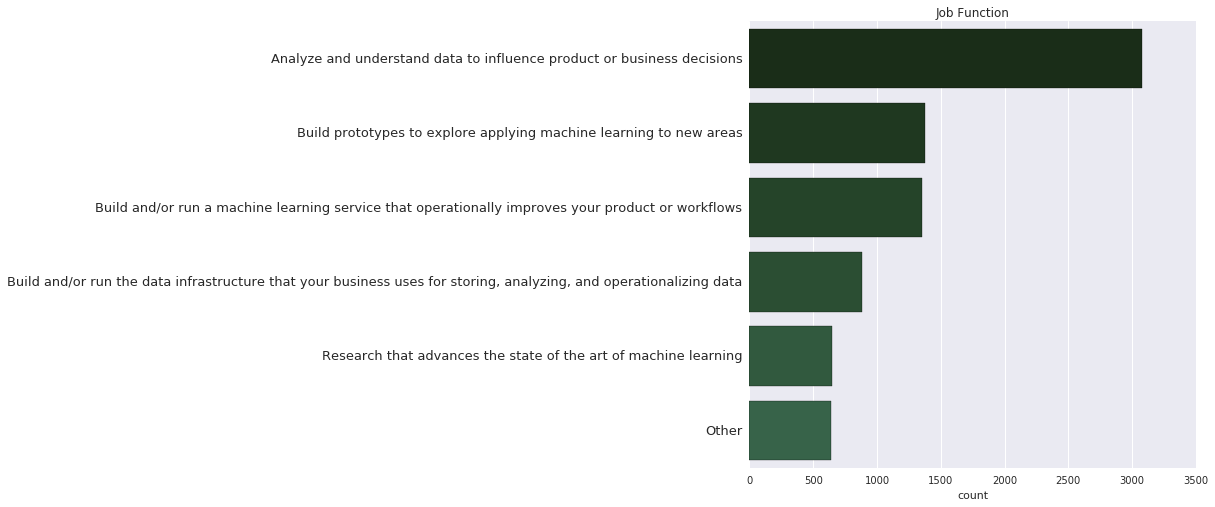

In [28]:
#Jobs they do as a data Scientist
plt.figure(figsize=(8,8))
plt.title('Job Function')
#A countplot is like a histogram for a discrete range. It just goes through a column, keeping a running tab of the values it finds.
ax = sns.countplot(y='JobFunctionSelect', data=MC, order=MC['JobFunctionSelect'].value_counts().index)
plt.setp(ax.get_yticklabels(), fontsize=13)
plt.ylabel('');

/usr/local/lib/python3.5/dist-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


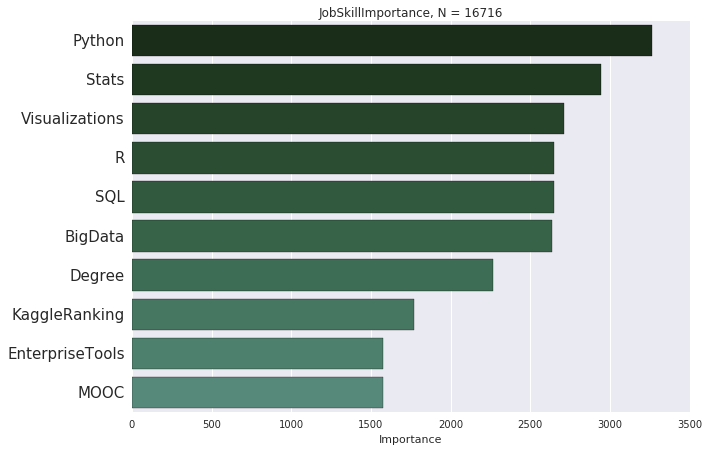

In [29]:
#Importatnt Job skills
df = plot_importance_questions(MC, 'JobSkillImportance', figsize=(10,7), drop_last=3)

/usr/local/lib/python3.5/dist-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


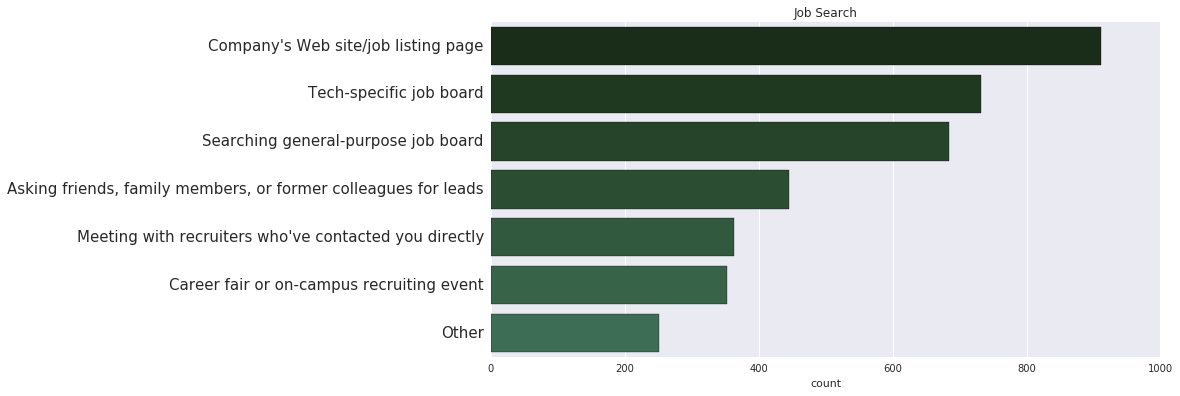

In [30]:
# Resourses for Job Search
plt.figure(figsize=(12,6))
plt.title('Job Search')
#A countplot is like a histogram for a discrete range. It just goes through a column, keeping a running tab of the values it finds.
ax = sns.countplot(y='JobSearchResource', data=MC, order=MC['JobSearchResource'].value_counts().index)
plt.setp(ax.get_yticklabels(), fontsize=15)
plt.ylabel('');

/usr/local/lib/python3.5/dist-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


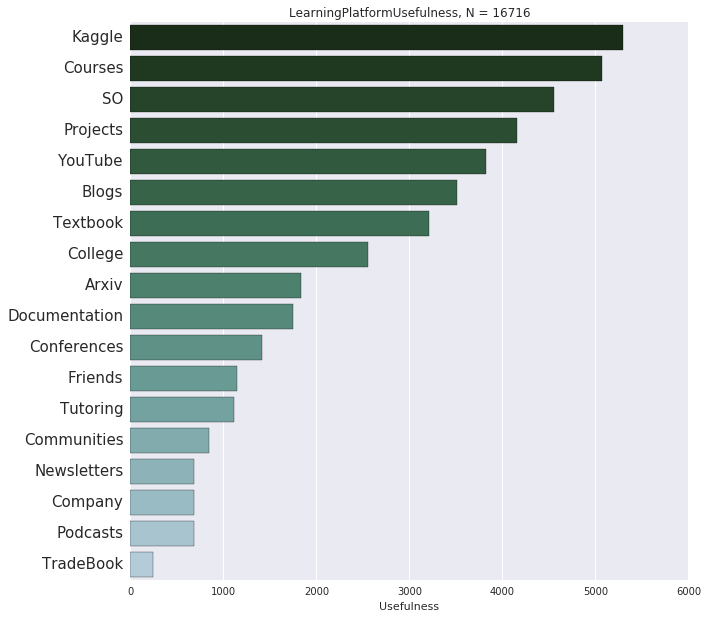

In [31]:
#Usefulness of Different Learning Platform
sns.set_palette(sns.cubehelix_palette(20, start=1.7, reverse=True))
plot_usefulness_questions(MC, 'LearningPlatformUsefulness', figsize=(10,10));

/usr/local/lib/python3.5/dist-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


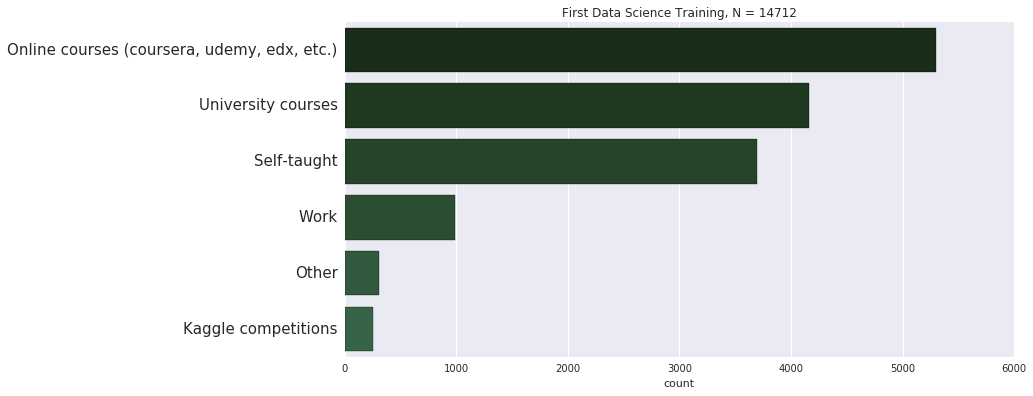

In [32]:
# First Data Science Training
plt.figure(figsize=(12,6))
plt.title('First Data Science Training, N = ' + str(MC.FirstTrainingSelect.count()))
#A countplot is like a histogram for a discrete range. It just goes through a column, keeping a running tab of the values it finds.
ax = sns.countplot(y='FirstTrainingSelect', data=MC, order=MC['FirstTrainingSelect'].value_counts().index)
plt.setp(ax.get_yticklabels(), fontsize=15)
plt.ylabel('');
plt.show()

/usr/local/lib/python3.5/dist-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


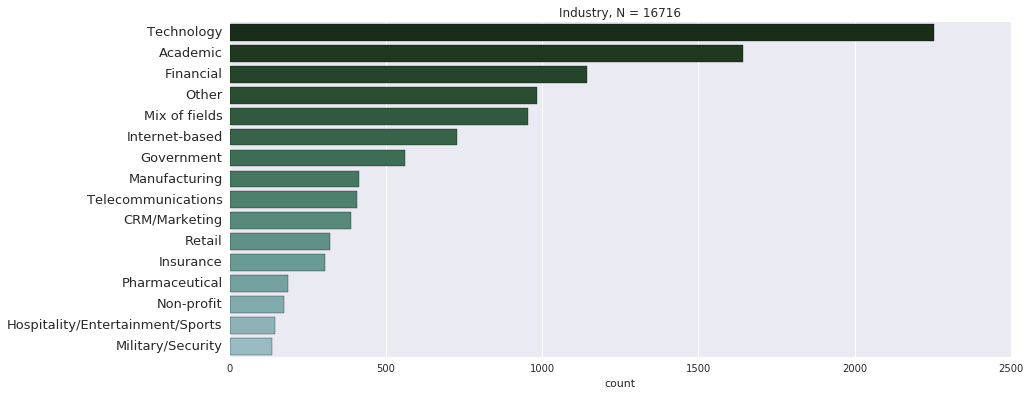

In [33]:
# Industries that uses Data Science
sns.set_palette(sns.cubehelix_palette(20, start=1.7, reverse=True))
plt.figure(figsize=(14,6))
plt.title('Industry, N = ' + str(len(MC.EmployerIndustry)))
ax = sns.countplot(y='EmployerIndustry', data=MC, order=MC['EmployerIndustry'].value_counts().index)

#This is the only way I figured out how to change the labels on the y-axis.
plt.setp(ax.get_yticklabels(), fontsize=13)
plt.ylabel('')
plt.show()

/usr/local/lib/python3.5/dist-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


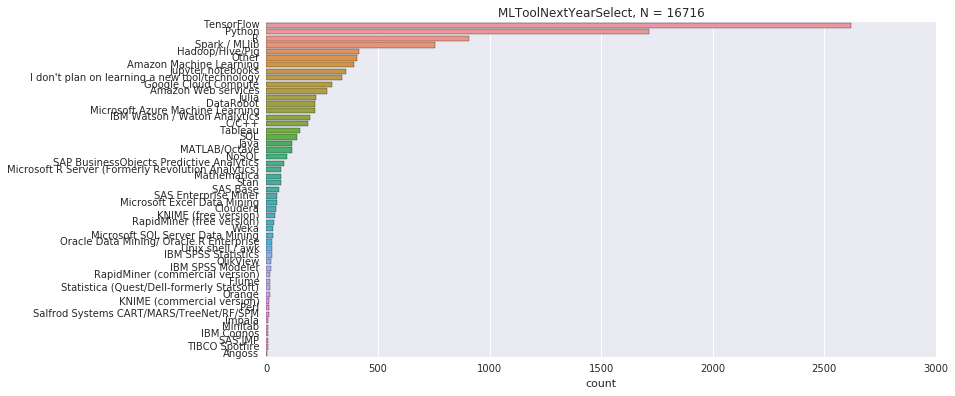

In [34]:
# Tools that will be used in the next year 
sns.set_palette(sns.cubehelix_palette(13, start=1.7, reverse=True))
select_all_that_apply_plot(MC, 'MLToolNextYearSelect', figsize=(10,8))

/usr/local/lib/python3.5/dist-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


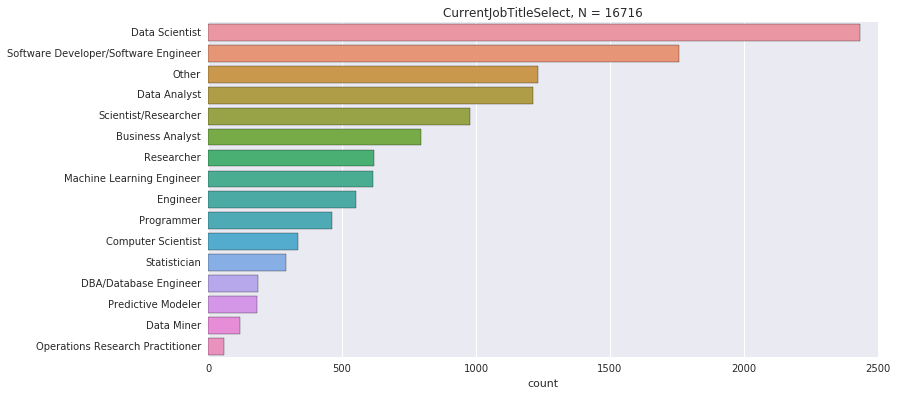

In [35]:
#Current Job Title position
sns.set_palette(sns.cubehelix_palette(13, start=1.7, reverse=True))
select_all_that_apply_plot(MC, 'CurrentJobTitleSelect', figsize=(120,36))

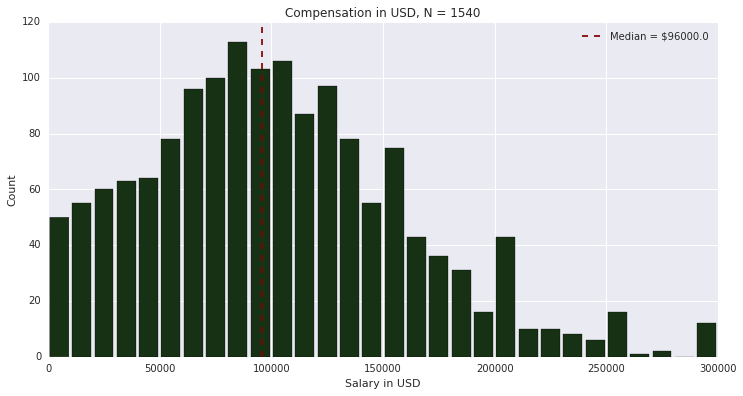

In [36]:
#Compensation

#Isolating dollars
money = MC.CompensationAmount[MC.CompensationCurrency == 'USD']


money = money.str.replace(',', '')
money.dropna(inplace=True)
money = pd.to_numeric(money, errors='coerce')
money.sort_values(inplace=True)


money_median = money.median()
money_less = money[money <= 300000]

#Making the plot
money_less.hist(bins=30, histtype='bar', figsize=(12,6), rwidth=0.85)
plt.axvline(x=money_median, linestyle='--', color='darkred', label='Median = $' + str(money_median))
plt.xlabel('Salary in USD')
plt.ylabel('Count')
plt.title('Compensation in USD, N = ' + str(len(money)))
plt.legend(loc = 'upper right');


The respondents were from all over the world and thus responded in their local currency. I first needed to isolate those who got paid in dollars. I thought about converting everything, as the conversion rates are included in the downloadable dataset, but since I'm interested in work here in the US, I thought that looking at this subset of respondents made sense.

/usr/local/lib/python3.5/dist-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


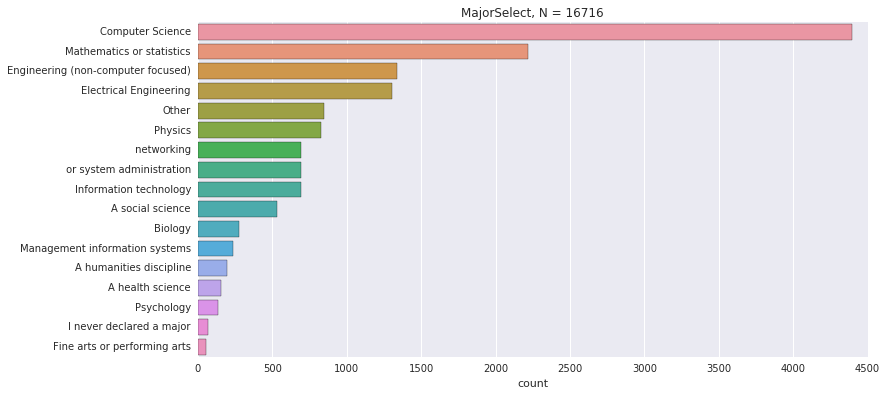

In [37]:
# Graduation Major
sns.set_palette(sns.cubehelix_palette(13, start=1.7, reverse=True))
select_all_that_apply_plot(MC, 'MajorSelect', figsize=(120,36))

/usr/local/lib/python3.5/dist-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


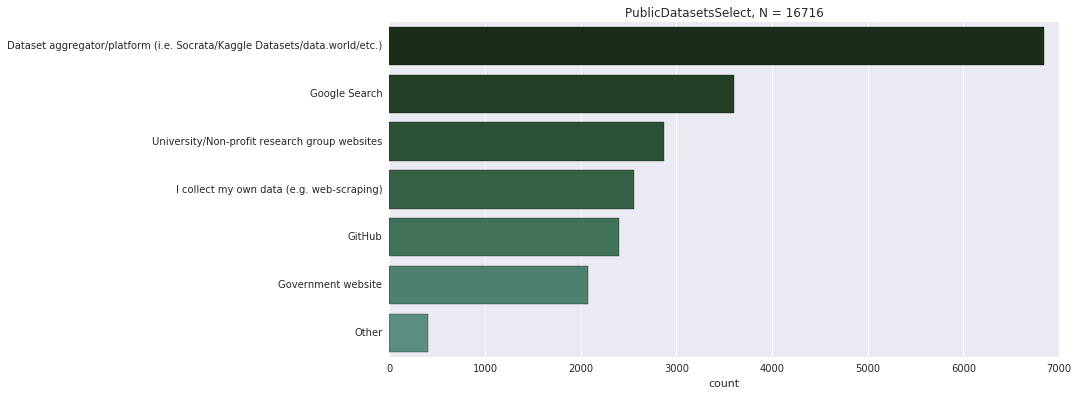

In [38]:
#Getting Dataset
sns.set_palette(sns.cubehelix_palette(13, start=1.7, reverse=True))
select_all_that_apply_plot(MC, 'PublicDatasetsSelect', figsize=(120,36))

/usr/local/lib/python3.5/dist-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


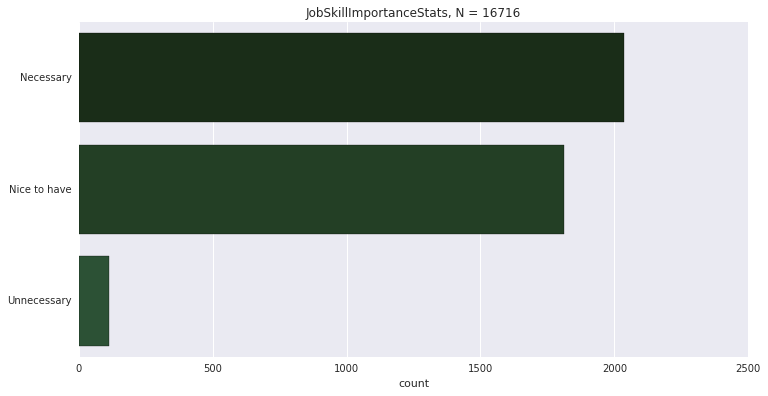

In [39]:
# Statistics Understanding
sns.set_palette(sns.cubehelix_palette(13, start=1.7, reverse=True))
select_all_that_apply_plot(MC, 'JobSkillImportanceStats', figsize=(120,36))

/usr/local/lib/python3.5/dist-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


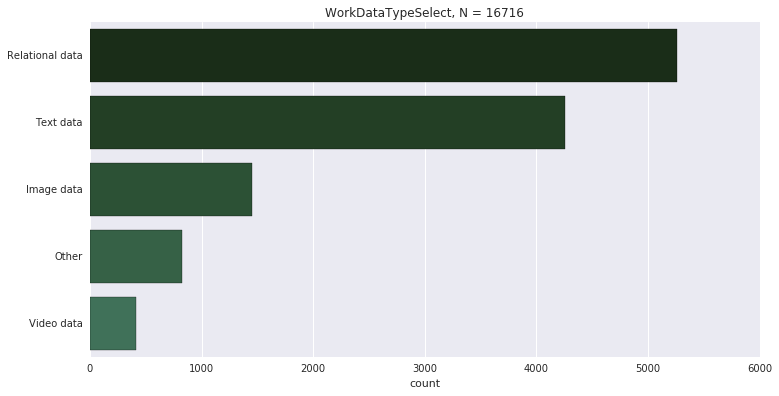

In [40]:
#Different Types of Data
sns.set_palette(sns.cubehelix_palette(13, start=1.7, reverse=True))
select_all_that_apply_plot(MC, 'WorkDataTypeSelect', figsize=(120,36))

/usr/local/lib/python3.5/dist-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


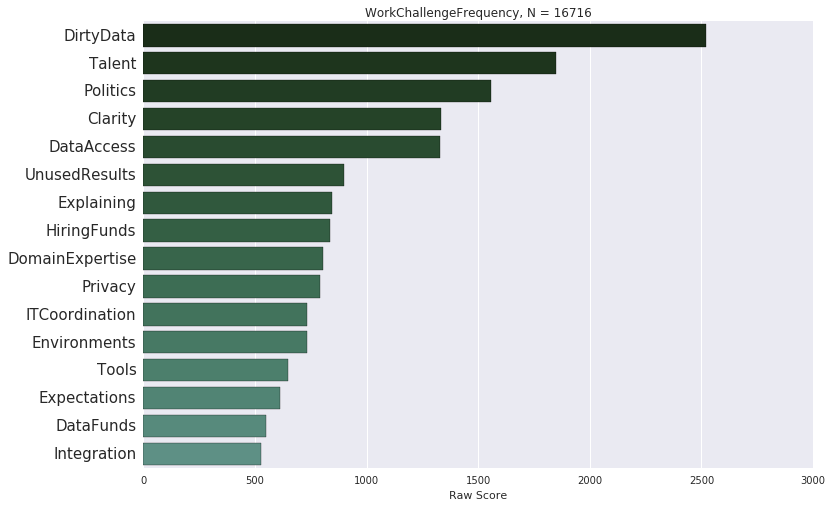

In [41]:
#Challenging Fields
sns.set_palette(sns.cubehelix_palette(30, start=1.7, reverse=True))
plot_frequency_questions(MC, 'WorkChallengeFrequency', figsize=(12,8), drop_last=6);

In [ ]:
The challengin work , Most Data Scientist for 

/usr/local/lib/python3.5/dist-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


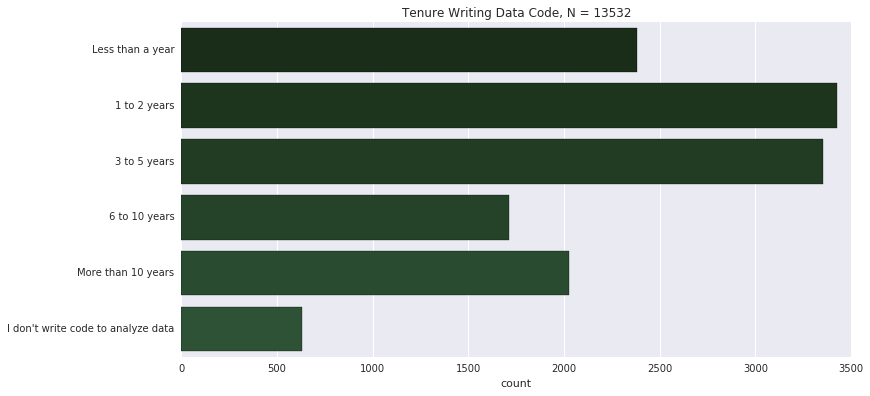

In [42]:
# Tenure Writing Data Code
plt.figure(figsize=(12,6))
plt.title('Tenure Writing Data Code, N = ' + str(MC.Tenure.count()))

#A countplot is like a histogram for a discrete range. It just goes through a column, keeping a running tab of the values it finds.
sns.countplot(data=MC, y='Tenure', order=['Less than a year', '1 to 2 years', '3 to 5 years', '6 to 10 years', 'More than 10 years', 'I don\'t write code to analyze data']);
plt.ylabel('');

Here again we see that majority of the respondents are relatively new to the field, with a clear majority having only been writing data-oriented code for less than five years. Companies are realizing the value that a strong data science team can bring

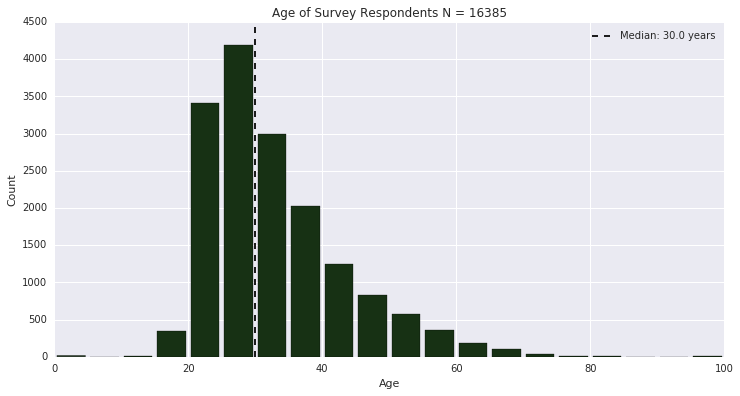

Fraction under 40 years old = 0.778475711893


In [44]:
#Creates a histogram of the Age column of the multiple choice DataFrame (called MC). The 'rwidth' just changes bar width
#to add a little aesthetic space.

MC.Age.hist(bins=20, figsize=(12,6), rwidth=0.85)
plt.axvline(x=MC.Age.median(), color='black', linestyle='--', label='Median: ' + str(MC.Age.median()) + ' years')
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Age of Survey Respondents N = ' + str(MC.Age.count()))
plt.legend(loc='upper right')
plt.show()

fraction_under_40 = MC.Age[MC.Age < 40].count() / len(MC.Age)
print("Fraction under 40 years old = " + str(fraction_under_40))

#### --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

## 3. Web Scrapping of Indeed

In [45]:
def parse(url):
    html = requests.get(url)
    soup = BeautifulSoup(html.content, 'html.parser', from_encoding="utf-8")
    df = pd.DataFrame(columns=["Title","Location","Company","Salary", "Synopsis"])
    for each in soup.find_all(class_= "result" ):
        try: 
            title = each.find(class_='jobtitle').text.replace('\n', '')
        except:
            title = 'None'
        try:
            location = each.find('span', {'class':"location" }).text.replace('\n', '')
        except:
            location = 'None'
        try: 
            company = each.find(class_='company').text.replace('\n', '')
        except:
            company = 'None'
        try:
            salary = each.find('span', {'class':'no-wrap'}).text
        except:
            salary = 'None'
        synopsis = each.find('span', {'class':'summary'}).text.replace('\n', '')
        df = df.append({'Title':title, 'Location':location, 'Company':company, 'Salary':salary, 'Synopsis':synopsis}, ignore_index=True)
    return df

In [46]:
URL ='https://www.indeed.ca/jobs?q=data+scientist&l=Toronto%2C+ON'

In [47]:
parse(URL)

Title         Location  \
0                                      Data Scientist      Toronto, ON   
1                                        Technologist      Toronto, ON   
2                                      Data Scientist      Toronto, ON   
3                       Senior Director, Data Science      Toronto, ON   
4                        Data Scientist - Toronto, ON      Toronto, ON   
5         Machine Learning Developer / Data Scientist      Toronto, ON   
6           Research Scientist, Google Brain (Canada)      Toronto, ON   
7                                      Data Scientist      Toronto, ON   
8                  Data Scientist - Customer Insights      Toronto, ON   
9                      DATA AND INFORMATION SCIENTIST      Toronto, ON   
10            Geospatial Data Scientist (Entry Level)  Mississauga, ON   
11  Research Scientist, Machine Learning and Cogni...      Toronto, ON   
12                           Data Scientist (Toronto)      Toronto, ON   
13                                     Data Scientist      Markham, ON   
14                Machine Learning Research Scientist      Toronto, ON   
15                              Data Mining Scientist      Markham, ON   
16                       Data Science Engineer Intern  Mississauga, ON   
17                                     Data Scientist      Toronto, ON   
18                                     Data Scientist      Toronto, ON   
19                                     Data Scientist      Toronto, ON   
20                                     Data Scientist      Toronto, ON   
21                                     Data Scientist      Toronto, ON   
22                                     Data Scientist      Toronto, ON   
23                                     Data Scientist      Toronto, ON   
24                             Level 2 Data Scientist      Toronto, ON   
25                  Data Scientist - Machine Learning      Toronto, ON   

                                              Company  \
0                                            Properly   
1                                              SANOFI   
2                                       autoTRADER.ca   
3                                      Loblaw Digital   
4                                          Scotiabank   
5                                              Rangle   
6                                              Google   
7                                            Properly   
8                                TELUS Communications   
9       Ministry of the Environment and Climate Ch...   
10                                          RNYCollab   
11                                                 EY   
12                                               Wish   
13                  The Nielsen Company - Engineering   
14                             Rubikloud Technologies   
15                                      Huawei Canada   
16                                         Quartic.ai   
17                                          Wysdom.AI   
18                                      Telus Digital   
19                                            TD Bank   
20                                        Capital One   
21                                      autoTRADER.ca   
22                                        Thoughtwire   
23                                           Quanfury   
24                                                RBC   
25                                                RBC   

                                         Salary  \
0   \n                $70,000 - $100,000 a year   
1                                          None   
2                                          None   
3                                          None   
4                                          None   
5                                          None   
6                                          None   
7   \n                $70,000 - $100,000 a year   
8                                          None   

In [48]:
url_template = "http://www.indeed.ca/jobs?q=data+scientist+%2420%2C000&l={}&start={}"
max_results_per_city = 2000 # Set this to a high-value (5000) to generate more results. 
# Crawling more results, will also take much longer. First test your code on a small number of results and then expand.
i = 0
results = []
df_more = pd.DataFrame(columns=["Title","Location","Company","Salary", "Synopsis"])
for city in set(['Toronto','British+Columbia','Alberta','Montreal','Vancouver','Ottawa']):
    for start in range(0, max_results_per_city, 10):
        # Grab the results from the request (as above)
        url = url_template.format(city, start)
        # Append to the full set of results
        html = requests.get(url)
        soup = BeautifulSoup(html.content, 'html.parser', from_encoding="utf-8")
        for each in soup.find_all(class_= "result" ):
            try: 
                title = each.find(class_='jobtitle').text.replace('\n', '')
            except:
                title = None
            try:
                location = each.find('span', {'class':"location" }).text.replace('\n', '')
            except:
                location = None
            try: 
                company = each.find(class_='company').text.replace('\n', '')
            except:
                company = None
            try:
                salary = each.find('span', {'class':'no-wrap'}).text
            except:
                salary = None
            try:
                synopsis = each.find('span', {'class':'summary'}).text.replace('\n', '')
            except:
                synopsis = None
            df_more = df_more.append({'Title':title, 'Location':location, 'Company':company, 'Salary':salary, 'Synopsis':synopsis}, ignore_index=True)
            i += 1
            if i % 1000 == 0:  # Harris helped me build this counter to see how many. You can visibly see Harris's vernacular in the print statements.
                print('You have ' + str(i) + ' results. ' + str(df_more.dropna().drop_duplicates().shape[0]) + " of these aren't rubbish.")

You have 1000 results. 23 of these aren't rubbish.
You have 2000 results. 23 of these aren't rubbish.
You have 3000 results. 23 of these aren't rubbish.
You have 4000 results. 23 of these aren't rubbish.
You have 5000 results. 23 of these aren't rubbish.
You have 6000 results. 38 of these aren't rubbish.
You have 7000 results. 38 of these aren't rubbish.
You have 8000 results. 38 of these aren't rubbish.
You have 9000 results. 38 of these aren't rubbish.
You have 10000 results. 38 of these aren't rubbish.
You have 11000 results. 39 of these aren't rubbish.
You have 12000 results. 39 of these aren't rubbish.
You have 13000 results. 39 of these aren't rubbish.
You have 14000 results. 39 of these aren't rubbish.
You have 15000 results. 39 of these aren't rubbish.
You have 16000 results. 44 of these aren't rubbish.
You have 17000 results. 44 of these aren't rubbish.
You have 18000 results. 44 of these aren't rubbish.
You have 19000 results. 44 of these aren't rubbish.
You have 20000 result

In [49]:
df_more.to_csv('Indeed.csv', encoding='utf-8')

In [50]:
df_more = pd.read_csv('Indeed.csv')

In [51]:
df_more.drop('Unnamed: 0', axis=1, inplace=True)

In [52]:
df_more.head()

Title     Location            Company Salary  \
0                       Technologist  Toronto, ON             SANOFI    NaN   
1                     Data Scientist  Toronto, ON      autoTRADER.ca    NaN   
2  Data Scientist - Machine Learning  Toronto, ON                RBC    NaN   
3             Level 2 Data Scientist  Toronto, ON                RBC    NaN   
4       Data Scientist - Toronto, ON  Toronto, ON         Scotiabank    NaN   

                                            Synopsis  
0  Scientist Required Education:. Maintain accura...  
1                              We are looking for...  
2                              Joining the Digita...  
3                              As Level 2 Data Sc...  
4              Scotiabank has developed and built...

In [53]:
df_more.shape

(29404, 5)

In [54]:
def data_scientist(x):
    if 'Data Scientist' in x:
        return 1
    return 0

df_more['DataScientist'] = df_more['Title'].apply(data_scientist)

In [55]:
df_more[df_more.DataScientist != 0]

Title         Location  \
1                                         Data Scientist      Toronto, ON   
2                      Data Scientist - Machine Learning      Toronto, ON   
3                                 Level 2 Data Scientist      Toronto, ON   
4                           Data Scientist - Toronto, ON      Toronto, ON   
5            Machine Learning Developer / Data Scientist      Toronto, ON   
7                                         Data Scientist      Toronto, ON   
9                Geospatial Data Scientist (Entry Level)  Mississauga, ON   
10                    Data Scientist - Customer Insights      Toronto, ON   
11                              Data Scientist (Toronto)      Toronto, ON   
13                                        Data Scientist      Markham, ON   
15                                        Data Scientist      Toronto, ON   
16                                        Data Scientist      Toronto, ON   
18                                        Data Scientist      Toronto, ON   
19                     Data Scientist - Machine Learning      Toronto, ON   
20                                        Data Scientist      Toronto, ON   
21                                        Data Scientist      Toronto, ON   
22                                        Data Scientist      Toronto, ON   
23                                        Data Scientist      Toronto, ON   
25                                        Data Scientist      Toronto, ON   
27                     Data Scientist - Machine Learning      Toronto, ON   
28                                Level 2 Data Scientist      Toronto, ON   
29                                        Data Scientist      Toronto, ON   
30                                        Data Scientist   Woodbridge, ON   
31         Data Scientist / Engineer (Data Architecture)      Toronto, ON   
32                                        Data Scientist      Toronto, ON   
33                             Data Scientist - Big Data      Toronto, ON   
34                                        Data Scientist      Toronto, ON   
36                              Data Scientist - Toronto  Mississauga, ON   
38                                        Data Scientist      Toronto, ON   
40                                        Data Scientist      Toronto, ON   
...                                                  ...              ...   
29041  Intermediate Data Scientist to build out the a...     Edmonton, AB   
29053                                     Data Scientist     Edmonton, AB   
29066  Intermediate Data Scientist to build out the a...     Edmonton, AB   
29078                                     Data Scientist     Edmonton, AB   
29091  Intermediate Data Scientist to build out the a...     Edmonton, AB   
29103                                     Data Scientist     Edmonton, AB   
29116  Intermediate Data Scientist to build out the a...     Edmonton, AB   
29128                                     Data Scientist     Edmonton, AB   
29141  Intermediate Data Scientist to build out the a...     Edmonton, AB   
29153                                     Data Scientist     Edmonton, AB   
29166  Intermediate Data Scientist to build out the a...     Edmonton, AB   
29178                                     Data Scientist     Edmonton, AB   
29191  Intermediate Data Scientist to build out the a...     Edmonton, AB   
29203                                     Data Scientist     Edmonton, AB   
29216  Intermediate Data Scientist to build out the a...     Edmonton, AB   
29228                                     Data Scientist     Edmonton, AB   
29241  Intermediate Data Scientist to build out the a...     Edmonton, AB   
29253                                     Data Scientist     Edmonton, AB   
29266  Intermediate Data Scientist to build out the a...     Edmonton, AB   
29278                                     Data Scientist     Edmonton, AB   
29291  Intermediate Data Scientist to build out

In [56]:
def business_analyst(x):
    if 'Business Analyst' in x:
        return 1
    return 0

df_more['BusinessAnalyst'] = df_more['Title'].apply(business_analyst)

In [57]:
df_more[df_more.BusinessAnalyst != 0]

Title         Location  \
201                                     Business Analyst      Toronto, ON   
227                                     Business Analyst      Toronto, ON   
286    Technical Business Analyst - PriceMetrix, New ...      Toronto, ON   
297                             Product Business Analyst      Toronto, ON   
302    Big Data Platform Post Trade Gateway Business ...  Mississauga, ON   
312    Technical Business Analyst - PriceMetrix, New ...      Toronto, ON   
323                             Product Business Analyst      Toronto, ON   
328    Big Data Platform Post Trade Gateway Business ...  Mississauga, ON   
355    Big Data Platform Regulatory & Surveillance Bu...  Mississauga, ON   
381    Big Data Platform Regulatory & Surveillance Bu...  Mississauga, ON   
15181                               Sr. Business Analyst     Montréal, QC   
15206                               Sr. Business Analyst     Montréal, QC   
15259                               Sr. Business Analyst     Montréal, QC   
15284                               Sr. Business Analyst     Montréal, QC   
15309                               Sr. Business Analyst     Montréal, QC   
15334                               Sr. Business Analyst     Montréal, QC   
15360                               Sr. Business Analyst     Montréal, QC   
15385                               Sr. Business Analyst     Montréal, QC   
15409                               Sr. Business Analyst     Montréal, QC   
15434                               Sr. Business Analyst     Montréal, QC   
15460                               Sr. Business Analyst     Montréal, QC   
15485                               Sr. Business Analyst     Montréal, QC   
15510                               Sr. Business Analyst     Montréal, QC   
15535                               Sr. Business Analyst     Montréal, QC   
15560                               Sr. Business Analyst     Montréal, QC   
15585                               Sr. Business Analyst     Montréal, QC   
15610                               Sr. Business Analyst     Montréal, QC   
15635                               Sr. Business Analyst     Montréal, QC   
15661                               Sr. Business Analyst     Montréal, QC   
15686                               Sr. Business Analyst     Montréal, QC   
...                                                  ...              ...   
19274                               Sr. Business Analyst     Montréal, QC   
19299                               Sr. Business Analyst     Montréal, QC   
19324                               Sr. Business Analyst     Montréal, QC   
19349                               Sr. Business Analyst     Montréal, QC   
19374                               Sr. Business Analyst     Montréal, QC   
19399                               Sr. Business Analyst     Montréal, QC   
19424                               Sr. Business Analyst     Montréal, QC   
19449                               Sr. Business Analyst     Montréal, QC   
19474                               Sr. Business Analyst     Montréal, QC   
19499                               Sr. Business Analyst     Montréal, QC   
19524                               Sr. Business Analyst     Montréal, QC   
19549                               Sr. Business Analyst     Montréal, QC   
19574                               Sr. Business Analyst     Montréal, QC   
19599                               Sr. Business Analyst     Montréal, QC   
19624                               Sr. Business Analyst     Montréal, QC   
19649                               Sr. Business Analyst     Montréal, QC   
19674                               Sr. Business Analyst     Montréal, QC   
19699                               Sr. Business Analyst     Montréal, QC   
19724                               Sr. Business Analyst     Montréal, QC   
19749                               Sr. Business Analyst     Montréal, QC   
19774                               Sr. Busines

In [58]:
print(df_more.loc[[19610],['Synopsis']])

                                                Synopsis
19610                              NMR, MS, automated...


In [59]:
def data_manager(x):
    if 'Data Manager' in x:
        return 1
    return 0

df_more['DataManager'] = df_more['Title'].apply(data_manager)

In [81]:
df_more[df_more.DataManager != 0]

Empty DataFrame
Columns: [Title, Location, Company, Salary, Synopsis, DataScientist, BusinessAnalyst, DataManager]
Index: []

#### By scrapping the indeed, we fond the required skill set sought by the industry for the position of data analyst and business analyst(saved as csv files using pandas data frame) , However we were not able to find any jobs posting for the position of Data Manager

## 4. Regression Analysis for find the top feature based on the salary

In [61]:
def replace_usefulness(df, question_stem):
    
    #Create a new DataFrame from only the questions we care about
    filtered = pd.DataFrame(df.loc[:,df.columns.str.startswith(question_stem)])
    
    #Replace words with useful numbers
    filtered.replace({
        'Very useful' : 1,
        'Somewhat useful' : 0.5,
        'Not Useful' : 0,
        np.nan : 0
    }, inplace=True)
    
    return filtered

In [62]:
def replace_frequency(df, question_stem):
    
    filtered = pd.DataFrame(df.loc[:,df.columns.str.startswith(question_stem)])
    filtered.replace({
        'Most of the time' : 1,
        'Often' : 0.7,
        'Sometimes' : 0.3,
        'Rarely' : 0.1,
        np.nan : 0
    }, inplace=True)
    
    return filtered

In [63]:
#Repeat previous function but for importance.
def replace_importance(df, question_stem):
   
    filtered = pd.DataFrame(df.loc[:,df.columns.str.startswith(question_stem)])
    
    if 'Necessary' in filtered.values:
        replacements = {
            'Necessary' : 1,
            'Nice to have': 0.5,
            'Unnecessary' : 0,
            np.nan : 0
        }
    else:
        replacements = {
            'Very Important' : 1,
            'Somewhat important' : 0.5,
            'Not important' : 0,
            np.nan : 0
        }
    
    filtered.replace(replacements, inplace=True)
    
    return filtered

In [64]:
#Importing the multiple choice responses
MC = pd.read_csv('multipleChoiceResponses.csv', encoding='latin-1', low_memory=False)

#Importing conversion rates
FX = pd.read_csv('conversionRates.csv', encoding='latin-1', low_memory=False)
FX = FX.drop(FX.columns[0], axis=1)

# Feature Importance
Use f_regression to determine feature importance relating to the compensation amount in USD. This gives us idea what skills/methods are the most relavent in order to get a high paying job in data science.

In [65]:
#Drop rows which has no compensation or compensation currency
MC_clean = MC.loc[MC.CompensationAmount.notnull()]
MC_clean = MC_clean.loc[MC_clean.CompensationCurrency.notnull()]
MC_clean = MC_clean.reset_index()

In [69]:
#Convert compensation to float
compensationAmountAdj_clean = ['0' if x == '-' else x for x in MC_clean['CompensationAmount']]
compensationAmountAdj_series = pd.Series(compensationAmountAdj_clean)
compensationAmountAdj_float = pd.to_numeric(compensationAmountAdj_series.str.replace(',', ''))
ccy = MC_clean.CompensationCurrency

In [70]:
#Convert compensation to USD
for i in range(0, len(ccy)):
    
    tmp = FX.loc[FX['originCountry'] == MC_clean.CompensationCurrency.iloc[i]].exchangeRate
    if len(tmp) == 1:
        compensationAmountAdj_float[i] = compensationAmountAdj_float[i] * tmp.iloc[0]
    else:
        compensationAmountAdj_float[i] = 0

In [71]:
#Set compensation in USD as the target variable y
y = compensationAmountAdj_float

In [72]:
from sklearn import linear_model
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor

In [73]:
# Function to find k most relativant featurers
# r_regression is used to determine feature importance
def rank_features(X, y, k):
    kBest = SelectKBest(f_regression, k=k)
    kBest.fit(X, y)
    x_new = kBest.transform(X) # not needed to get the score
    scores = kBest.scores_
    results = sorted(zip(map(lambda x: round(x, 4), kBest.scores_), X.columns.values), reverse=True)[0:k]
    print('Top', k, 'WorkToolsFrequency:\n')
    print("\n".join([x[1] for x in results]))
    

#### 1. WorkMethods

In [80]:
# Feature importance - WorkMethodsFrequency
k=10
X = replace_frequency(MC_clean, 'WorkMethodsFrequency')
rank_features(X,y,k)


Top 10 WorkToolsFrequency:

WorkMethodsFrequencySelect1
WorkMethodsFrequencySelect2
WorkMethodsFrequencyPCA
WorkMethodsFrequencyCross-Validation
WorkMethodsFrequencyDecisionTrees
WorkMethodsFrequencyRandomForests
WorkMethodsFrequencyTimeSeriesAnalysis
WorkMethodsFrequencyNeuralNetworks
WorkMethodsFrequencyKNN
WorkMethodsFrequencyTextAnalysis


#### 2. WorkChallenge

In [75]:
# Feature importance - WorkChallengeFrequency

k=5
X = replace_frequency(MC_clean, 'WorkChallengeFrequency')
rank_features(X,y,k)


Top 5 WorkToolsFrequency:

WorkChallengeFrequencyPrivacy
WorkChallengeFrequencyPolitics
WorkChallengeFrequencyITCoordination
WorkChallengeFrequencyUnusedResults
WorkChallengeFrequencyTalent


#### 3. JobSkill

In [76]:
# Feature importance - JobSkillImportance
k=10

X = replace_importance(MC_clean, 'JobSkillImportance')
rank_features(X,y,k)

Top 10 WorkToolsFrequency:

JobSkillImportanceBigData
JobSkillImportanceDegree
JobSkillImportanceStats
JobSkillImportanceEnterpriseTools
JobSkillImportancePython
JobSkillImportanceR
JobSkillImportanceSQL
JobSkillImportanceKaggleRanking
JobSkillImportanceMOOC
JobSkillImportanceVisualizations


/usr/local/lib/python3.5/dist-packages/sklearn/feature_selection/univariate_selection.py:298: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/usr/local/lib/python3.5/dist-packages/scipy/stats/_distn_infrastructure.py:1748: RuntimeWarning: invalid value encountered in greater
  cond1 = (scale > 0) & (x > self.a) & (x < self.b)
/usr/local/lib/python3.5/dist-packages/scipy/stats/_distn_infrastructure.py:1748: RuntimeWarning: invalid value encountered in less
  cond1 = (scale > 0) & (x > self.a) & (x < self.b)
/usr/local/lib/python3.5/dist-packages/scipy/stats/_distn_infrastructure.py:1749: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


#### 4. Learning Platform usefulness

In [77]:
# Feature importance - LearningPlatformUsefulness

k=5
X = replace_usefulness(MC_clean, 'LearningPlatformUsefulness')
rank_features(X,y,k)


Top 5 WorkToolsFrequency:

LearningPlatformUsefulnessYouTube
LearningPlatformUsefulnessTextbook
LearningPlatformUsefulnessCourses
LearningPlatformUsefulnessKaggle
LearningPlatformUsefulnessProjects


## 5 Summary

Part A
Course Outline for MIE1624 Introduction to Data Science and Analytics


Part 1: Introduction


Lecture 1: Defining Data Science:-
    What is data science,
    Different paths/backgrounds to data science,
    Data Science Application,
    Different specialization in Data science,
    How the field of data science is evolving/Data science in the next 10 years. 

Lecture 2: Data Science tools and technologies:-
    Various programming environment used in Data Science,
    R Vs Python Vs SQL and various software distributions (Anaconda Jupyter Notebook, Data Scientist Workbench, PyCharm etc.).

Lecture 3: Python Programming for Data Science:-
    Python Basics - Basic syntax, Variables, Objects,Control statements, Conditions,Functions,
    Python Libraries - Numpy, Pandas, Sklearn,Regex, Etc.
    Python Key Data Structures - Lists, Dictionary, Tuples,
    Working with Databases,
    Illustration with example.

Part 2: Getting The Data

Lecture 4: Introduction to Data Gathering:-
    Types of Data
    Finding Datasets
    Traditional and Present Data Collection Methods
    Data Extraction Methods(Web scraping, Using API, Data banks)
    Data cleansing methodologies 

Part 3: Exploring the Data

Lecture 5: Visualization:-
    Types of visualization
    Introduction to visualization tools: IBM Watson Analytics, Seaborn, Pandas profiling and visual analytics.
    Dealing with missing values, outliers and imbalanced data
    Data Transformations

Part 4: Introduction to Machine Learning and Data Modelling

Lecture 6: Statistics:-
    Basic Statistic - Mean, Variance, Correlation Etc.
    Random Variables and Probability Distributions and its significance
    Central Limit Theorem
    P values, Confidence Intervals
    Hypothesis testing

Lecture 7: Linear Algebra & Numerical methods:-
    Why is it necessary to understand these math concepts to understand the algorithms better
    PD & PSD Matrix and its significance, 
    Convex, Concave, Continuous functions and its significance in Machine Learning algorithm.
    Numerical Methods Gradient descent, Newton method, Gauss Elimination,
    Time Series Analysis

Lecture 8: Data Modeling and Supervised Learning Algorithms:-
    What is Modelling
    What are the Modelling Process
    Linear regression 
    Logistic regression

Lecture 9: Supervised Learning Algorithms:-
    Decision trees; ensemble methods; k-NN; svm
    Feature selection/engineering; PCA
    Bias-variance tradeoff
    Cross validation
    Hyper-parameter tuning

Lecture 10: Unsupervised Learning Algorithms:-
    K-means; c-means; hierarchical clustering; DBSCAN

Lecture 11: Intro to AI:-
    What is AI,
    AI Algorithms,
    Reinforcement Learning,
    Deep Learning,
    Artificial Neural Nets,

Part 5: Communication

Lecture 12: Communicating Data Science Results:-
    Working with people,
    Presenting for Data Scientists,
    Privacy, Security and Ethics,
    Reproducibility and Cloud Computing,
    Code Sharing,



###### ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

PART B

Program Length: 1 year full-time including a 4 months paid summer internship

Course Requirement: 4 mandatory courses + 2 elective courses + research project + workshops

Curriculum:

I Fall

1. Introduction to Data Science : Refer to MIE 1624 course design

2. Data Mining and Machine Learning : Supervised and unsupervised learning algorithms; neural networks; PCA; model selection and generalization; topics in deep learning and reinforcement learning

3. Data Visualization and Engineering : Visualization toolkits: ggplot2, d3.js, Tableau; high dimensional visualization; dimension reduction, Data preprocessing methods; feature engineering and selections

4. Communications for Data Scientist I workshop : Effective oral communication in presentations, collaborations and negotiations


II Winter 

1. Mining Big Data : Preprocessing, storing and mining big data using Spark, Hadoop and NoSql databases

2. Probabilistic Learning and Reasoning (elective) : Inference in probabilistic models: regressions; graphical models; variational/exact inference; variational autoencoders; gaussian processes 

3. Deep Learning (elective) : Feedforward neural networks, recurrent neural networks and convolutional neural networks

4. Reinforcement Learning (elective): MDP; policy gradients; Q-learning; deep Q-network; model based RL

5. Computer Vision (elective): Geometric computer vision; image formation & filtering; motion analysis; deep learning for computer vision

6. Natural Language Processing (elective): Stream-based text processing; probabilistic approach to NLP; syntactic processing

7. Communications for Data Scientist II workshop : Effective written communication in writing reports or research paper in data science

8. Interview preparation workshop

III Summer

1. Internship

2. Research project : Major research project on topics in data science under the guidance of the supervisor; The project will be submitted in technical report format with a powerpoint presentation



###### ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

###### PART C

Program Length: 12 months full-time including a 4 months summer internship 

Course Requirement:  6 mandatory courses (3 Management and 3 Analytical) + 2 elective courses 

Students Portfolio:
1. UG level quantitative skills and  Basic Programming skills assumed.
2. Targeted at  students who have minimum of three to four years of work experience. 

Curriculum  
I Management Skills  (Any 3 Courses)
1. Managing data science projects (Project Management)
2. Into to project management, PMBOK, Project Life Cycle, Scheduling and Project Monitoring
3. Data Driven Decision Making: Critical thinking, Logical reasoning, Scientific methods in decision making, 
4. Embracing Leadership and Growth : Conflict resolution, Empower with clarity, Leading Meetings, Leadership in global context
5. Financial Management : Interest theory, Bonds, Company FInance, Balance Sheets, Managing finance for project, Financial Projection. 
6. Managerial Communication : Communicating in meetings, team communication, writing workshops 

II Analytical Skills (Any three courses)

1. Mathematics for Analytics : Statistics, Linear Algebra, Matrix algebra, optimization techniques 
2. MIE 1624 Introduction to Data Science and Analytics : Courses introduction various skills that are in demand in the field of data analytics
3. Machine Learning and AI( Managerial Perspective): Supervised and unsupervised learning algorithms; neural networks; PCA; model selection and generalization
4. Big Data Platform and Tools: Various visualization tools, Available data science tools in the industry (SAS, Tableau etc)
5. Database management system : Managing big data set, hardware requirements
6. Introduction to Upcoming topics in Data Science: Tensorflow, Spark, Hadoop, Hive, Amazon Machine Learning

III Electives (Any two from the list) 

1. Financial Analytics
2. Healthcare Analytics
3. Marketing Analytics 
4. Social Media Analytics 
5. Operations and Supply Chain Analytics
6. Retail Analytics
7. Ethics & Policy in Data Management 
